In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('BTC-USD_stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


# Normalization of Feature

In [3]:
df = (df - df.mean())/df.std(ddof=0)
print(df.head())

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2017-01-01 -1.127270 -1.127174 -1.126278 -1.126117  -1.126117 -1.203614
2017-01-02 -1.125501 -1.125773 -1.124308 -1.124932  -1.124932 -1.199674
2017-01-03 -1.124338 -1.125144 -1.123017 -1.123815  -1.123815 -1.201634
2017-01-04 -1.123185 -1.119433 -1.121835 -1.118206  -1.118206 -1.193174
2017-01-05 -1.117501 -1.117865 -1.128781 -1.125355  -1.125355 -1.184423


### Creating Target for the Model
Intutively our model should predict for closing of the next day based on the given data.

In [4]:
df['Target'] = df['Close'].shift(-1)
df['Target'] = df['Target'].fillna(df['Target'].mean())

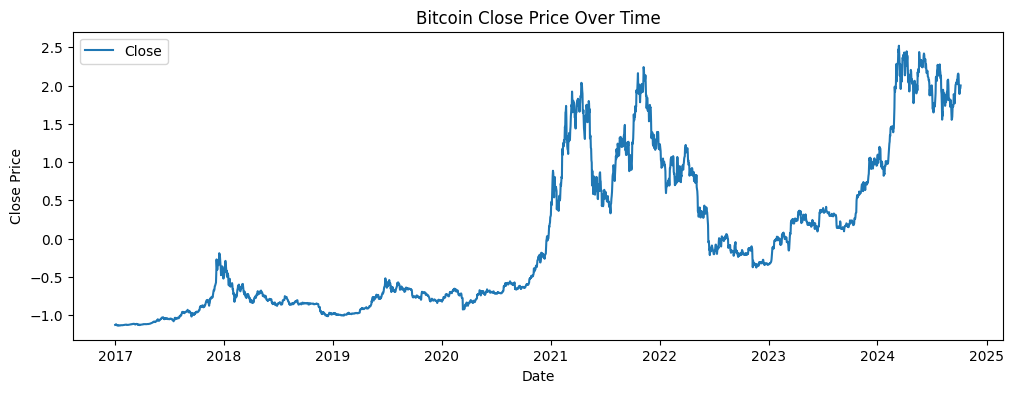

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Close'], label='Close')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

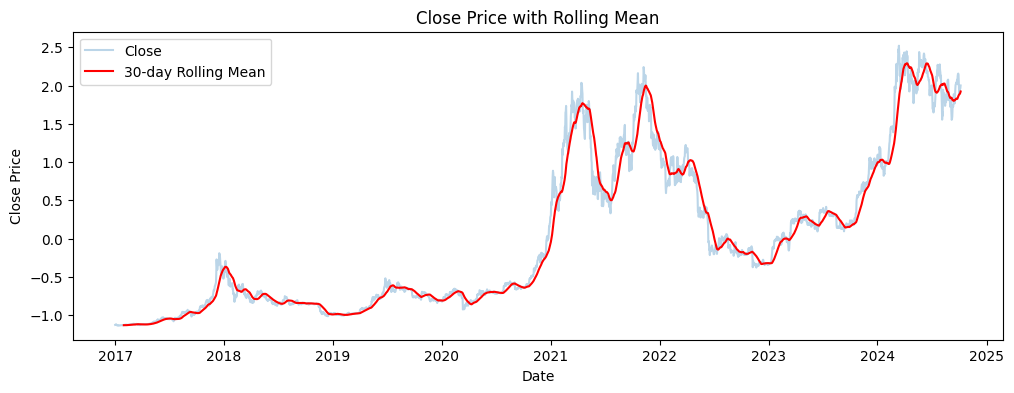

In [6]:
rolling = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(12,4))
plt.plot(df.index, df['Close'], alpha=0.3, label='Close')
plt.plot(df.index, rolling, color='red', label='30-day Rolling Mean')
plt.title('Close Price with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomp = seasonal_decompose(df['Close'].dropna(), model='multiplicative', period=365)
# fig = decomp.plot()
# fig.set_size_inches(12, 9)
# plt.show()

# Model Function
As we are using Mutliple Variable Linear Regression Model.
$$
y = f(x) = \sum_{i=0}^n w_i x_i + b
$$

In [8]:
features = df.loc[:, df.columns != 'Target']
features.info()
target = df['Target'].to_numpy()
target.shape
features.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2836 entries, 2017-01-01 to 2024-10-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2836 non-null   float64
 1   High       2836 non-null   float64
 2   Low        2836 non-null   float64
 3   Close      2836 non-null   float64
 4   Adj Close  2836 non-null   float64
 5   Volume     2836 non-null   float64
dtypes: float64(6)
memory usage: 155.1 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,-1.127270,-1.127174,-1.126278,-1.126117,-1.126117,-1.203614
2017-01-02,-1.125501,-1.125773,-1.124308,-1.124932,-1.124932,-1.199674
2017-01-03,-1.124338,-1.125144,-1.123017,-1.123815,-1.123815,-1.201634
2017-01-04,-1.123185,-1.119433,-1.121835,-1.118206,-1.118206,-1.193174
2017-01-05,-1.117501,-1.117865,-1.128781,-1.125355,-1.125355,-1.184423


In [9]:
def model_fn(X, w, b):
    # X - Vector of features
    # w - Vector of parameters
    # b - Scaler value of independant paramter
    y_hat = np.dot(X,w) + b
    return y_hat

In [10]:
# Testing for vectorization
feature_0 = features.iloc[0].to_numpy()
w = np.arange(2,14,2)
print(feature_0.shape, w.shape, len(features))
b = 10
y = model_fn(feature_0, w, b)
print(y)

(6,) (6,) 2836
-38.23437275600813


# Loss/Error Function
To get the error function using sq. mean value error fn

$$
L = \frac{1}{2m} \sum_{i_0}^k (\hat y_i - y_i)^2
$$
Where k = total number of dataset values, total rows in dataset

$$
\begin{align}
L =\frac{1}{2m}  \sum_{i=0}^k (w_i^0 x_i^0 + w_i^1 x_i^1 + w_i^2 x_i^2  + ... +  w_i^n x_i^n + b - y^i)^2  \\
L =\frac{1}{2m}  \sum_{i=0}^k (w_i\cdot x_i + b - y^i)^2 
\end{align}
$$

In [11]:
def cost_fn(X, Y, w, b):
    X = X.to_numpy()
    m = len(X)
    l = 0
    for i in range(m):
        feature_vector_i = X[i]
        y_i = Y[i]
        error = np.dot(feature_vector_i, w) + b - y_i
        l += error ** 2
    l /= (2 * m)
    return l

## Gradiant Descent
The algorithm is used to find the global minima of a Linear Regression. Bascially to minimise the error function
```
# dl_dw = partial derivate wrt w
# dl_db = partial derivate wrt w
until converge {
    w = w + alpha  * dl_dw
    b = b + alpha + dl_db
}

```

For the error function
$$
L =\frac{1}{2m}  \sum_{i=0}^k (w_i\cdot x_i + b - y^i)^2 
$$

# equation for dl/dw and dl/db. in maths mon

In [12]:
def compute_pderivative(X, Y, w, b):
    m = len(X)
    dl_dw = np.zeros_like(w)
    dl_db = 0
    
    for i in range(m):
        x_i = X.iloc[i].to_numpy()
        y_i = Y[i]
        tmp = (np.dot(x_i, w) + b) - y_i
        dl_dw += tmp * x_i
        dl_db += tmp

    dl_dw /= m
    dl_db /= m

    return dl_dw, dl_db        
        

In [13]:
# print(features.iloc[1].to_numpy())
# dl_dw, dl_db = compute_pderivative(features, target, np.ones(6), 0)
# print(dl_dw, dl_db)

In [14]:
def gradient_descent(X, Y, w_init, b_init, alpha, iterations):
    w = w_init
    b = b_init
    cost_hist = []

    for i in range(iterations):
        # compute gradients
        dl_dw, dl_db = compute_pderivative(X, Y, w, b)

        # update parameters
        w = w - alpha * dl_dw
        b = b - alpha * dl_db

        # compute cost every iteration
        cost = cost_fn(X, Y, w, b)
        cost_hist.append(cost)

        # optional: print progress every 100 iterations
        if i % 100 == 0:
            print(f"Iter {i}: cost={cost:.4f}, b={b:.4f}")
    return w, b, cost_hist

In [15]:
print(features.shape)  # should be (m, 6)print(features.shape)  # should be (m, 6)
print(target.shape)  # should be (m,)

(2836, 6)
(2836,)


In [16]:
dl_dw, dl_db = compute_pderivative(features, target, np.ones(6), 0.0)
print(dl_dw, dl_db)

[4.52512387 4.53312624 4.51156986 4.52371208 4.52371208 3.09492091] -0.000397219320331923


In [17]:
w_init = np.ones(6)
b_init = 0.0
alpha = .003
iterations = 10000
w, b, cost_hist = gradient_descent(features, target, w_init, b_init, alpha, iterations)

Iter 0: cost=10.2674, b=0.0000
Iter 100: cost=0.4661, b=0.0001
Iter 200: cost=0.0551, b=0.0002
Iter 300: cost=0.0270, b=0.0002
Iter 400: cost=0.0183, b=0.0003
Iter 500: cost=0.0128, b=0.0003
Iter 600: cost=0.0092, b=0.0003
Iter 700: cost=0.0069, b=0.0003
Iter 800: cost=0.0053, b=0.0004
Iter 900: cost=0.0042, b=0.0004
Iter 1000: cost=0.0035, b=0.0004
Iter 1100: cost=0.0031, b=0.0004
Iter 1200: cost=0.0028, b=0.0004
Iter 1300: cost=0.0026, b=0.0004
Iter 1400: cost=0.0024, b=0.0004
Iter 1500: cost=0.0023, b=0.0004
Iter 1600: cost=0.0023, b=0.0004
Iter 1700: cost=0.0022, b=0.0004
Iter 1800: cost=0.0022, b=0.0004
Iter 1900: cost=0.0022, b=0.0004
Iter 2000: cost=0.0022, b=0.0004
Iter 2100: cost=0.0022, b=0.0004
Iter 2200: cost=0.0022, b=0.0004
Iter 2300: cost=0.0022, b=0.0004
Iter 2400: cost=0.0022, b=0.0004
Iter 2500: cost=0.0022, b=0.0004
Iter 2600: cost=0.0022, b=0.0004
Iter 2700: cost=0.0022, b=0.0004
Iter 2800: cost=0.0022, b=0.0004
Iter 2900: cost=0.0022, b=0.0004
Iter 3000: cost=0.002

In [19]:
print(w, b)

[0.18321833 0.19016063 0.20461754 0.20930076 0.20930076 0.00252957] 0.000397219320332351


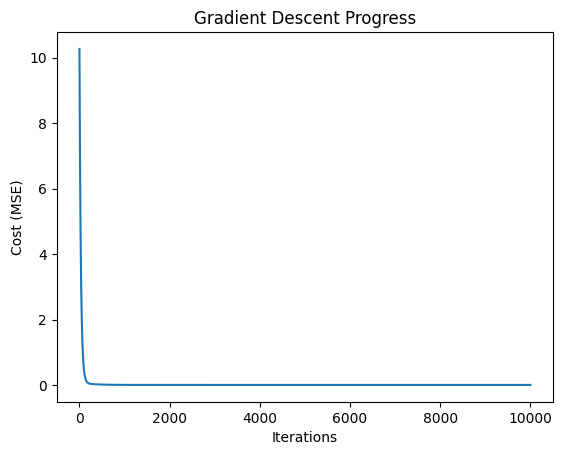

In [22]:
plt.plot(range(len(cost_hist)), cost_hist)
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")
plt.title("Gradient Descent Progress")
plt.show()

In [25]:
y_pred = []
for i in range(len(features)):
    x = features.iloc[i].to_numpy()
    y_pred.append(model_fn(x, w, b))

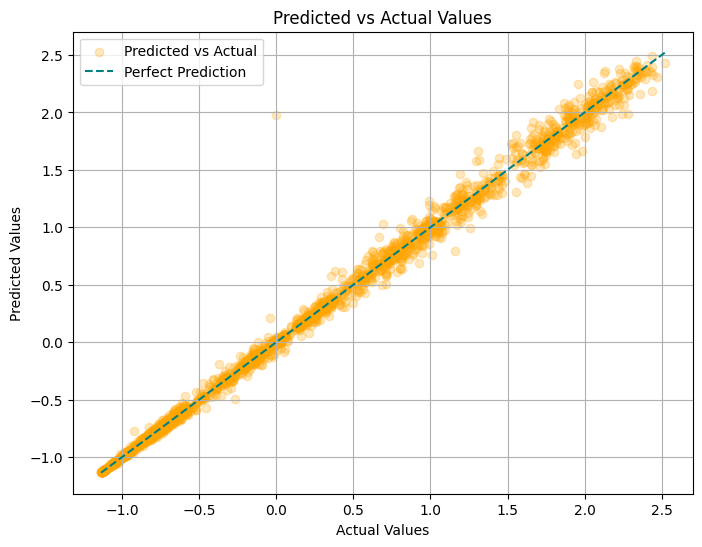

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(target, y_pred, color='orange', alpha=0.25, label='Predicted vs Actual')

# Diagonal line for reference (perfect prediction)
plt.plot([min(target), max(target)], [min(target), max(target)], color='teal', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()